 - Step 0: Label all client nodes as “not served”. Go to Step 1.
 - Step 1: If all client nodes are already labelled “served”, then STOP. Otherwise, start at one of the centres (or ‘depots’) with a new staff member, initialize the work duration of this staff member as zero, and go to Step 2.
 - Step 2: From the current node, pick the nearest neighbour client node j that is “not served”. If the current work duration and the walking distance to j add up to more than 7 hours, then this staff member has completed their shift, go to Step 1. Otherwise, go to Step 3.
 - Step 3: Add the walking distance to j as well as the task duration at j to the current work duration. Update the label of node j from “not served” to “served”. If the updated work duration is more than 7 hours, then this staff member has completed their shift, go to Step 1. Otherwise, go to Step 2.

Depots are 71, 142, 280, 3451, 6846, and 7649

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import itertools
import copy
import networkx as nx
import scipy as sci

In [55]:
CareDist_Matrix = np.loadtxt(open("CareDistances-FULL.csv", "rb"), dtype=int, delimiter=",", skiprows=1)
CareDist_Matrix

array([[   0,    4,   38, ..., 8360, 8507, 8545],
       [   4,    0, 1280, ...,  777, 1025, 1017],
       [  38, 1280,    0, ..., 1408, 1515, 1433],
       ...,
       [8360,  777, 1408, ...,    0, 1530, 1449],
       [8507, 1025, 1515, ..., 1530,    0,   82],
       [8545, 1017, 1433, ..., 1449,   82,    0]])

# Create the Data
The code below creates the data for the problem.

In [57]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = CareDist_Matrix # yapf: disable
    data['num_vehicles'] = 1
    data['depot'] = 71
    return data

The distance matrix is an array whose i, j entry is the distance from location i to location j in miles, where the array indices correspond to the locations

Note: The order of the locations in the distance matrix is arbitrary, and is unrelated to the order of locations in any solution to the TSP.

The data also includes:

 - The number of vehicles in the problem, which is 1 because this is a TSP. (For a vehicle routing problem (VRP), the number of vehicles can be greater than 1.)
 - The depot: the start and end location for the route. In this case, the depot is 71, which is one of 7 depotsbm.

# Create the routing model
The following code in the main section of the programs creates the index manager (manager) and the routing model (routing). 

The method manager.IndexToNode converts the solver's internal indices (which you can safely ignore) to the numbers for locations. 

Location numbers correspond to the indices for the distance matrix.

In [61]:
from ortools.constraint_solver import pywrapcp

data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

The inputs to RoutingIndexManager are:

 - The number of rows of the distance matrix, which is the number of locations (including the depot).
 - The number of vehicles in the problem.
 - The node corresponding to the depot.

# Create the distance callback
To use the routing solver, you need to create a distance (or transit) callback: a function that takes any pair of locations and returns the distance between them. The easiest way to do this is using the distance matrix.

The following function creates the callback and registers it with the solver as transit_callback_index.

In [62]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

The callback accepts two indices, from_index and to_index, and returns the corresponding entry of the distance matrix.

# Set the cost of travel
The arc cost evaluator tells the solver how to calculate the cost of travel between any two locations—in other words, the cost of the edge (or arc) joining them in the graph for the problem. The following code sets the arc cost evaluator.

In [63]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In this example, the arc cost evaluator is the transit_callback_index, which is the solver's internal reference to the distance callback. This means that the cost of travel between any two locations is just the distance between them. However, in general the costs can involve other factors as well.

# Set search parameters
The following code sets the default search parameters and a heuristic method for finding the first solution:

In [66]:
from ortools.constraint_solver import routing_enums_pb2

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

The code sets the first solution strategy to PATH_CHEAPEST_ARC, which creates an initial route for the solver by repeatedly adding edges with the least weight that don't lead to a previously visited node (other than the depot). For other options, see [First solution strategy.](https://developers.google.com/optimization/routing/routing_options#first_sol_options)

# Add the solution printer
The function that displays the solution returned by the solver is shown below. The function extracts the route from the solution and prints it to the console.

In [67]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)

The function displays the optimal route and its distance, which is given by ObjectiveValue().

# Solve and print the solution
Finally, you can call the solver and print the solution:

In [68]:
solution = routing.SolveWithParameters(search_parameters)
if solution:
    print_solution(manager, routing, solution)

Objective: 28895 miles
Route for vehicle 0:
 71 -> 102 -> 131 -> 139 -> 23 -> 188 -> 69 -> 132 -> 115 -> 75 -> 32 -> 229 -> 216 -> 12 -> 5 -> 4 -> 11 -> 90 -> 65 -> 58 -> 18 -> 50 -> 153 -> 61 -> 159 -> 24 -> 183 -> 42 -> 53 -> 167 -> 201 -> 195 -> 204 -> 130 -> 79 -> 13 -> 152 -> 46 -> 94 -> 6 -> 8 -> 25 -> 147 -> 203 -> 118 -> 205 -> 64 -> 194 -> 60 -> 91 -> 124 -> 82 -> 214 -> 179 -> 43 -> 72 -> 126 -> 110 -> 100 -> 117 -> 226 -> 182 -> 45 -> 165 -> 187 -> 149 -> 55 -> 40 -> 101 -> 133 -> 80 -> 209 -> 1 -> 0 -> 37 -> 98 -> 107 -> 171 -> 81 -> 189 -> 210 -> 141 -> 62 -> 181 -> 17 -> 197 -> 26 -> 68 -> 38 -> 161 -> 144 -> 196 -> 29 -> 228 -> 109 -> 28 -> 192 -> 10 -> 213 -> 84 -> 234 -> 175 -> 76 -> 74 -> 35 -> 85 -> 113 -> 106 -> 219 -> 52 -> 160 -> 218 -> 67 -> 223 -> 211 -> 231 -> 163 -> 158 -> 178 -> 198 -> 173 -> 208 -> 127 -> 177 -> 128 -> 199 -> 93 -> 27 -> 92 -> 134 -> 155 -> 162 -> 166 -> 227 -> 87 -> 140 -> 170 -> 174 -> 99 -> 108 -> 143 -> 21 -> 230 -> 112 -> 97 -> 207 -> 1

This returns the solution and displays the optimal route.

In [29]:
CareDist = pd.read_csv (r'CareDistances-FULL.csv', header=1, delimiter=',', index_col="Unnamed: 0")
CareDist.head()

,Unnamed: 0,4,38,71,90,94,101,142,163,164,...,8206,8232,8236,8255,8271,8300,8358,8360,8507,8545
0,4,0,1280,1762,1406,1589,1312,941,1098,1020,...,1377,321,1469,1398,1753,1762,846,777,1025,1017
1,38,1280,0,681,202,385,956,1639,1003,1520,...,1817,1178,411,2029,1370,681,1603,1408,1515,1433
2,71,1762,681,0,503,0,1512,2110,1524,0,...,2323,1660,342,2511,1926,0,2084,1890,1996,0
3,90,1406,202,503,0,0,1082,1765,1129,1646,...,1943,1304,355,2155,1496,503,1728,1534,1640,1559
4,94,1589,385,0,0,0,1264,0,1311,1829,...,2126,1487,226,2338,1679,338,1911,1717,1823,1742


In [20]:
c = np.tile(CareDist.columns, len(CareDist))
i = np.repeat(CareDist.index, len(CareDist.columns))
v = np.ravel(CareDist)

Expanded_CareDist = pd.DataFrame({'Node1':i, 'Node2':c, 'Distance':v})

In [21]:
Expanded_CareDist

,Node1,Node2,Distance
0,4,4,0
1,4,38,1280
2,4,71,1762
3,4,90,1406
4,4,94,1589
...,...,...,...
55691,8545,8300,1915
55692,8545,8358,335
55693,8545,8360,1449
55694,8545,8507,82


In [ ]:
df2 = pd.DataFrame()
for i in CareDist.index:
    for j in CareDist.columns:
        df2 = df2.append(pd.DataFrame({'Node1': [i], 'Node2': [j], 'Distance': [CareDist.at[i, j]]}), ignore_index=True)

In [130]:
CareDist = df2
CareDist.head()

,Node1,Node2,Distance
0,4,4,0
1,4,38,1280
2,4,71,1762
3,4,90,1406
4,4,94,1589


In [25]:
G = nx.from_pandas_adjacency(CareDist)
weights = nx.get_edge_attributes(G, 'weight')
print(weights)

NetworkXError: ('Columns must match Indices.', '[2048, 1538, 6658, 4, 1540, 4100, 5639, 520, 2056, 8195, 8201, 8206, 1039, 3091, 3606, 5655, 5143, 1560, 4120, 5665, 5669, 38, 8232, 554, 2091, 8236, 3118, 1071, 3120, 1073, 4655, 1076, 4661, 4150, 568, 2619, 3643, 4669, 3647, 3648, 8255, 71, 5706, 8271, 90, 1626, 1116, 2139, 94, 607, 1631, 4703, 101, 7270, 5223, 5227, 8300, 2670, 1136, 1138, 2680, 7289, 5757, 2176, 3719, 7304, 2698, 5259, 6796, 653, 142, 3214, 2192, 5261, 3218, 5264, 4758, 1175, 664, 2713, 7320, 2717, 671, 7328, 3234, 163, 164, 6819, 8358, 8360, 3241, 3242, 683, 2736, 6322, 7346, 3764, 7352, 4794, 6331, 5308, 6846, 196, 3268, 6856, 201, 6857, 4300, 7372, 1231, 213, 216, 2265, 3801, 1758, 4322, 7396, 1767, 4839, 6891, 6898, 3828, 760, 4859, 1788, 3839, 4356, 4357, 6405, 5895, 1808, 3348, 3862, 280, 1304, 1310, 3359, 1824, 5408, 6432, 5415, 4398, 1327, 304, 2354, 5939, 6451, 6454, 6966, 1848, 1337, 3897, 6967, 6972, 8507, 5950, 5958, 6983, 4936, 336, 2384, 3408, 1363, 6993, 7512, 7514, 864, 8545, 5474, 4966, 3431, 1388, 3436, 7020, 1907, 5492, 7028, 6007, 3451, 5500, 5501, 1918, 1407, 7549, 1412, 4484, 1926, 2442, 6540, 7567, 5520, 2451, 7573, 918, 1430, 7578, 7068, 5023, 6048, 7071, 7591, 5545, 940, 4525, 7599, 3507, 4531, 1973, 3509, 4535, 1467, 1468, 4027, 3518, 6078, 7108, 1989, 5068, 7629, 8143, 464, 7120, 466, 2002, 985, 4570, 3040, 7649, 1508, 3052, 8172, 8177, 8179, 7158, 4603, 5630] not in columns')

In [30]:
import networkx as nx

G = nx.from_pandas_adjacency(CareDist)
weights = nx.get_edge_attributes(G, 'weight')


NetworkXError: ('Columns must match Indices.', '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235] not in columns')

In [26]:
(pd.DataFrame(weights.keys(), columns=['node1', 'node2'])
    .assign(Distance=weights.values()))

NameError: name 'weights' is not defined

In [31]:
CareDur = pd.read_csv (r'CareDurations.txt', header=0, delimiter='	')
print (CareDur)

     UserID  Duration (minutes)
0         4                   9
1        38                   8
2        90                  10
3        94                  29
4       101                  21
..      ...                 ...
225    8300                  29
226    8358                  20
227    8360                  22
228    8507                  27
229    8545                  17

[230 rows x 2 columns]


In [32]:
CareDist = pd.merge(Expanded_CareDist, CareDur, left_on='Node1', right_on='UserID')
CareDist.drop(["UserID"], axis=1, inplace=True)

In [33]:
CareDist['Duration (seconds)'] = CareDist['Duration (minutes)'] * 60
CareDist.drop(["Duration (minutes)"], axis=1, inplace=True)

In [34]:
Care = CareDist
Care

,Node1,Node2,Distance,Duration (seconds)
0,4,4,0,540
1,4,38,1280,540
2,4,71,1762,540
3,4,90,1406,540
4,4,94,1589,540
...,...,...,...,...
54275,8545,8300,1915,1020
54276,8545,8358,335,1020
54277,8545,8360,1449,1020
54278,8545,8507,82,1020


In [35]:
Edges = Care
Edges.drop(Edges[Edges.Distance == 0].index, inplace=True)
Edges.rename(columns={'Distance': 'Distance (seconds)'}, inplace=True)
Edges.head()

,Node1,Node2,Distance (seconds),Duration (seconds)
1,4,38,1280,540
2,4,71,1762,540
3,4,90,1406,540
4,4,94,1589,540
5,4,101,1312,540


In [36]:
Nodes = CareDist['Node1'].unique()
Nodes = pd.DataFrame(Nodes, columns = ['ID'])
Nodes

,ID
0,4
1,38
2,90
3,94
4,101
...,...
225,8300
226,8358
227,8360
228,8507


In [37]:
# Create empty graph
Care_graph = nx.Graph()

In [38]:
# Add edges and edge attributes
for i, elrow in Edges.iterrows():
    Care_graph.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [39]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

8545
8507
{'Distance (seconds)': 82, 'Duration (seconds)': 1020}


In [40]:
# Add node attributes
for i, nlrow in Nodes.iterrows():
    Care_graph.nodes[nlrow['ID']].update(nlrow[1:].to_dict())

In [41]:
# Node list example
print(nlrow)

ID    8545
Name: 229, dtype: int64


In [42]:
# Preview first 5 edges
list(Care_graph.edges(data=True))[0:5]

[(4,
  '38',
  {'attr_dict': {'Distance (seconds)': 1280, 'Duration (seconds)': 540}}),
 (4,
  '71',
  {'attr_dict': {'Distance (seconds)': 1762, 'Duration (seconds)': 540}}),
 (4,
  '90',
  {'attr_dict': {'Distance (seconds)': 1406, 'Duration (seconds)': 540}}),
 (4,
  '94',
  {'attr_dict': {'Distance (seconds)': 1589, 'Duration (seconds)': 540}}),
 (4,
  '101',
  {'attr_dict': {'Distance (seconds)': 1312, 'Duration (seconds)': 540}})]

In [43]:
# Preview first 10 nodes
list(Care_graph.nodes(data=True))[0:10]

[(4, {}),
 ('38', {}),
 ('71', {}),
 ('90', {}),
 ('94', {}),
 ('101', {}),
 ('142', {}),
 ('163', {}),
 ('164', {}),
 ('196', {})]

In [50]:
class City:
    def __init__(self,x,y,num):
        self.x = x
        self.y = y
        self.number = num #identifying number
        
    def display(self):
        fill(0,255,255) #sky blue
        ellipse(self.x,self.y,10,10)
        noFill()

In [52]:
!pip install --upgrade --user ortools

In [51]:
def setup():
    size(600,600)
    background(0)
    city0 = City(100,200,0)
    city0.display()

setup()

NameError: name 'size' is not defined

# Graph Optimization with NetworkX in Python Tutorial

In [101]:
pip install --upgrade --user ortools# Grab edge list data hosted on Gist
edgelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/e570c38bcc72a8d102422f2af836513b/raw/89c76b2563dbc0e88384719a35cba0dfc04cd522/edgelist_sleeping_giant.csv')
edgelist.head()

,node1,node2,trail,distance,color,estimate
0,rs_end_north,v_rs,rs,0.30,red,0
1,v_rs,b_rs,rs,0.21,red,0
2,b_rs,g_rs,rs,0.11,red,0
3,g_rs,w_rs,rs,0.18,red,0
4,w_rs,o_rs,rs,0.21,red,0


In [48]:
nodelist = pd.read_csv('https://gist.githubusercontent.com/brooksandrew/f989e10af17fb4c85b11409fea47895b/raw/a3a8da0fa5b094f1ca9d82e1642b384889ae16e8/nodelist_sleeping_giant.csv')
nodelist.head()

,id,X,Y
0,b_bv,1486,732
1,b_bw,716,1357
2,b_end_east,3164,1111
3,b_end_west,141,1938
4,b_g,1725,771


In [49]:
# Create empty graph
g = nx.Graph()

In [50]:
# Add edges and edge attributes
for i, elrow in edgelist.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

In [51]:
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

o_gy2
y_gy2
{'trail': 'gy2', 'distance': 0.12, 'color': 'yellowgreen', 'estimate': 0}


In [52]:
# Add node attributes
for i, nlrow in nodelist.iterrows():
    g.nodes[nlrow['id']].update(nlrow[1:].to_dict())

In [53]:
# Node list example
print(nlrow)

id    y_rt
X      977
Y     1666
Name: 76, dtype: object


# Inspect Graph
## Edges

Your graph edges are represented by a list of tuples of length 3. The first two elements are the node names linked by the edge. The third is the dictionary of edge attributes.

In [54]:
# Preview first 5 edges
list(g.edges(data=True))[0:5]

[('rs_end_north',
  'v_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.3,
    'color': 'red',
    'estimate': 0}}),
 ('v_rs',
  'b_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.21,
    'color': 'red',
    'estimate': 0}}),
 ('v_rs',
  'v_bv',
  {'attr_dict': {'trail': 'v',
    'distance': 0.52,
    'color': 'violet',
    'estimate': 0}}),
 ('v_rs',
  'v_end_east',
  {'attr_dict': {'trail': 'v',
    'distance': 0.54,
    'color': 'violet',
    'estimate': 0}}),
 ('b_rs',
  'g_rs',
  {'attr_dict': {'trail': 'rs',
    'distance': 0.11,
    'color': 'red',
    'estimate': 0}})]

## Nodes
Similarly, your nodes are represented by a list of tuples of length 2. The first element is the node ID, followed by the dictionary of node attributes.

In [55]:
# Preview first 10 nodes
list(g.nodes(data=True))[0:10]

[('rs_end_north', {'X': 1772, 'Y': 172}),
 ('v_rs', {'X': 1793, 'Y': 484}),
 ('b_rs', {'X': 1747, 'Y': 700}),
 ('g_rs', {'X': 1676, 'Y': 775}),
 ('w_rs', {'X': 1646, 'Y': 947}),
 ('o_rs', {'X': 1724, 'Y': 1148}),
 ('y_rs', {'X': 1805, 'Y': 1246}),
 ('rs_end_south', {'X': 1865, 'Y': 1598}),
 ('rc_end_north', {'X': 867, 'Y': 618}),
 ('v_rc', {'X': 1288, 'Y': 934})]

## Summary Stats
Print out some summary statistics before visualizing the graph.

In [56]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 123
# of nodes: 77


# Visualize
## Manipulate Colors and Layout
**Positions**: First you need to manipulate the node positions from the graph into a dictionary. This will allow you to recreate the graph using the same layout as the actual trail map. Y is negated to transform the Y-axis origin from the topleft to the bottomleft.

In [57]:
# Define node positions data structure (dict) for plotting
node_positions = {node[0]: (node[1]['X'], -node[1]['Y']) for node in g.nodes(data=True)}

# Preview of node_positions with a bit of hack (there is no head/slice method for dictionaries).
dict(list(node_positions.items())[0:5])

{'rs_end_north': (1772, -172),
 'v_rs': (1793, -484),
 'b_rs': (1747, -700),
 'g_rs': (1676, -775),
 'w_rs': (1646, -947)}

# CPP Algorithm

# CPP Step 1: Find Nodes of Odd Degree
This is a pretty straightforward counting computation. You see that 36 of the 76 nodes have odd degree. These are mostly the dead-end trails (degree 1) and intersections of 3 trails. There are a handful of degree 5 nodes.

In [58]:
# Calculate list of nodes with odd degree
nodes_odd_degree = [v for v, d in g.degree() if d % 2 == 1]

# Preview
nodes_odd_degree[0:5]

['rs_end_north',
 'rs_end_south',
 'rc_end_north',
 'rc_end_south',
 'rt_end_north']

In [59]:
# Counts
print('Number of nodes of odd degree: {}'.format(len(nodes_odd_degree)))
print('Number of total nodes: {}'.format(len(g.nodes())))

Number of nodes of odd degree: 36
Number of total nodes: 77


# CPP Step 2: Find Min Distance Pairs
This is really the meat of the problem. You'll break it down into 5 parts:

1. Compute all possible pairs of odd degree nodes.
2. Compute the shortest path between each node pair calculated in 1.
3. Create a complete graph connecting every node pair in 1. with shortest path distance attributes calculated in 2.
4. Compute a minimum weight matching of the graph calculated in 3. (This boils down to determining how to pair the odd nodes such that the sum of the distance between the pairs is as small as possible).
5. Augment the original graph with the shortest paths between the node pairs calculated in 4.

## Step 2.1: Compute Node Pairs
You use the itertools combination function to compute all possible pairs of the odd degree nodes. Your graph is undirected, so we don't care about order: For example, (a,b) == (b,a).

In [60]:
# Compute all pairs of odd nodes. in a list of tuples
odd_node_pairs = list(itertools.combinations(nodes_odd_degree, 2))

# Preview pairs of odd degree nodes
odd_node_pairs[0:10]

[('rs_end_north', 'rs_end_south'),
 ('rs_end_north', 'rc_end_north'),
 ('rs_end_north', 'rc_end_south'),
 ('rs_end_north', 'rt_end_north'),
 ('rs_end_north', 'o_rt'),
 ('rs_end_north', 'y_rt'),
 ('rs_end_north', 'rt_end_south'),
 ('rs_end_north', 'rh_end_north'),
 ('rs_end_north', 'rh_end_tt_1'),
 ('rs_end_north', 'rh_end_tt_2')]

In [61]:
# Counts
print('Number of pairs: {}'.format(len(odd_node_pairs)))

Number of pairs: 630


## Step 2.2: Compute Shortest Paths between Node Pairs
This is the first step that involves some real computation. Luckily networkx has a convenient implementation of Dijkstra's algorithm to compute the shortest path between two nodes. You apply this function to every pair (all 630) calculated above in odd_node_pairs.

In [62]:
def get_shortest_paths_distances(graph, pairs, edge_weight_name):
    """Compute shortest distance between each pair of nodes in a graph.  Return a dictionary keyed on node pairs (tuples)."""
    distances = {}
    for pair in pairs:
        distances[pair] = nx.dijkstra_path_length(graph, pair[0], pair[1], weight=edge_weight_name)
    return distances

In [63]:
# Compute shortest paths.  Return a dictionary with node pairs keys and a single value equal to shortest path distance.
odd_node_pairs_shortest_paths = get_shortest_paths_distances(g, odd_node_pairs, 'distance')

# Preview with a bit of hack (there is no head/slice method for dictionaries).
dict(list(odd_node_pairs_shortest_paths.items())[0:10])

{('rs_end_north', 'rs_end_south'): 7,
 ('rs_end_north', 'rc_end_north'): 4,
 ('rs_end_north', 'rc_end_south'): 8,
 ('rs_end_north', 'rt_end_north'): 5,
 ('rs_end_north', 'o_rt'): 7,
 ('rs_end_north', 'y_rt'): 9,
 ('rs_end_north', 'rt_end_south'): 10,
 ('rs_end_north', 'rh_end_north'): 6,
 ('rs_end_north', 'rh_end_tt_1'): 7,
 ('rs_end_north', 'rh_end_tt_2'): 9}

## Step 2.3: Create Complete Graph
A complete graph is simply a graph where every node is connected to every other node by a unique edge.

The graph you create below has 36 nodes and 630 edges with their corresponding edge weight (distance).

create_complete_graph is defined to calculate it. The flip_weights parameter is used to transform the distance to the weight attribute where smaller numbers reflect large distances and high numbers reflect short distances. This sounds a little counter intuitive, but is necessary for Step 2.4 where you calculate the minimum weight matching on the complete graph.

Ideally you'd calculate the minimum weight matching directly, but NetworkX only implements a max_weight_matching function which maximizes, rather than minimizes edge weight. We hack this a bit by negating (multiplying by -1) the distance attribute to get weight. This ensures that order and scale by distance are preserved, but reversed.

In [64]:
def create_complete_graph(pair_weights, flip_weights=True):
    """
    Create a completely connected graph using a list of vertex pairs and the shortest path distances between them
    Parameters:
        pair_weights: list[tuple] from the output of get_shortest_paths_distances
        flip_weights: Boolean. Should we negate the edge attribute in pair_weights?
    """
    g = nx.Graph()
    for k, v in pair_weights.items():
        wt_i = - v if flip_weights else v
        g.add_edge(k[0], k[1], attr_dict={'distance': v, 'weight': wt_i})
    return g

In [65]:
# Generate the complete graph
g_odd_complete = create_complete_graph(odd_node_pairs_shortest_paths, flip_weights=True)

# Counts
print('Number of nodes: {}'.format(len(g_odd_complete.nodes())))
print('Number of edges: {}'.format(len(g_odd_complete.edges())))

Number of nodes: 36
Number of edges: 630


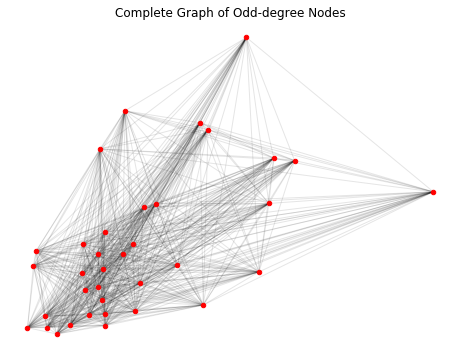

In [66]:
# Plot the complete graph of odd-degree nodes
plt.figure(figsize=(8, 6))
pos_random = nx.random_layout(g_odd_complete)
nx.draw_networkx_nodes(g_odd_complete, node_positions, node_size=20, node_color="red")
nx.draw_networkx_edges(g_odd_complete, node_positions, alpha=0.1)
plt.axis('off')
plt.title('Complete Graph of Odd-degree Nodes')
plt.show()

## Step 2.4: Compute Minimum Weight Matching
This is the most complex step in the CPP. You need to find the odd degree node pairs whose combined sum (of distance between them) is as small as possible. So for your problem, this boils down to selecting the optimal 18 edges (36 odd degree nodes / 2) from the hairball of a graph generated in 2.3.

Both the implementation and intuition of this optimization are beyond the scope of this tutorial... [like 800+ lines of code](https://networkx.github.io/documentation/networkx-1.10/_modules/networkx/algorithms/matching.html#max_weight_matching) and a body of academic literature beyond this scope.

In [71]:
# Compute min weight matching.
# Note: max_weight_matching uses the 'weight' attribute by default as the attribute to maximize.
odd_matching = nx.algorithms.max_weight_matching(g_odd_complete, True)

print('Number of edges in matching: {}'.format(len(odd_matching)))

Number of edges in matching: 18


In [72]:
# Preview of deduped matching
odd_matching

{('b_bv', 'rh_end_tt_3'),
 ('b_bw', 'y_rh'),
 ('b_end_east', 'rh_end_tt_2'),
 ('b_end_west', 'rh_end_south'),
 ('b_tt_3', 'rh_end_tt_4'),
 ('b_v', 'v_end_west'),
 ('o_rt', 'g_gy2'),
 ('o_tt', 'rc_end_south'),
 ('o_w_1', 'rt_end_south'),
 ('o_y_tt_end_west', 'rt_end_north'),
 ('rc_end_north', 'y_gy1'),
 ('rd_end_north', 'v_end_east'),
 ('rh_end_north', 'g_w'),
 ('rs_end_north', 'nature_end_west'),
 ('rs_end_south', 'y_gy2'),
 ('v_bv', 'rd_end_south'),
 ('w_bw', 'rh_end_tt_1'),
 ('y_rt', 'g_gy1')}

## Step 2.5: Augment the Original Graph
Now you augment the original graph with the edges from the matching calculated in 2.4. A simple function to do this is defined below which also notes that these new edges came from the augmented graph. You'll need to know this in 3. when you actually create the Eulerian circuit through the graph.

In [73]:
def add_augmenting_path_to_graph(graph, min_weight_pairs):
    """
    Add the min weight matching edges to the original graph
    Parameters:
        graph: NetworkX graph (original graph from trailmap)
        min_weight_pairs: list[tuples] of node pairs from min weight matching
    Returns:
        augmented NetworkX graph
    """

    # We need to make the augmented graph a MultiGraph so we can add parallel edges
    graph_aug = nx.MultiGraph(graph.copy())
    for pair in min_weight_pairs:
        graph_aug.add_edge(pair[0],
                           pair[1],
                           attr_dict={'distance': nx.dijkstra_path_length(graph, pair[0], pair[1]),
                                      'trail': 'augmented'}
                          )
    return graph_aug

In [74]:
# Confirm that your augmented graph adds the expected number (18) of edges:

# Create augmented graph: add the min weight matching edges to g
g_aug = add_augmenting_path_to_graph(g, odd_matching)

# Counts
print('Number of edges in original graph: {}'.format(len(g.edges())))
print('Number of edges in augmented graph: {}'.format(len(g_aug.edges())))

Number of edges in original graph: 123
Number of edges in augmented graph: 141
